In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.insert(0,"/content/drive/My Drive/Colab Notebooks/")

Mounted at /content/drive


##底层实现版本

In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
n_train,n_test,num_inputs,batch_size = 20,100,200,5
true_w,true_b = torch.ones((num_inputs,1))*0.01,0.05
train_data = d2l.synthetic_data(true_w,true_b,n_train)
train_iter = d2l.load_array(train_data,batch_size)
test_data = d2l.synthetic_data(true_w,true_b,n_test)
test_iter = d2l.load_array(test_data,batch_size,is_train=False)

In [4]:
def init_params():
  w = torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
  b = torch.zeros(1,requires_grad=True)
  return [w,b]

In [5]:
def l2_penalty(w):
  return torch.sum(w.pow(2))/2

In [6]:
def train(lambd):
  w,b = init_params()
  net,loss = lambda X:d2l.linreg(X,w,b),d2l.squared_loss
  num_epochs,lr=100,0.003
  animator = d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',xlim=[5,num_epochs],legend=['train', 'test'])
  for epoch in range(num_epochs):
    for X,y in train_iter:
      l = loss(net(X),y) + lambd * l2_penalty(w)
      l.sum().backward()
      d2l.sgd([w,b],lr,batch_size)
    if(epoch + 1) % 5 == 0:
      animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                               d2l.evaluate_loss(net, test_iter, loss)))
  print('w的L2范数是：',torch.norm(w).item())

w的L2范数是： 13.4701509475708


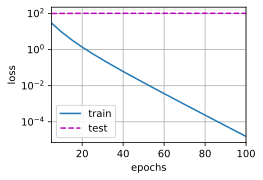

In [7]:
train(lambd=0)

w的L2范数是： 0.38964560627937317


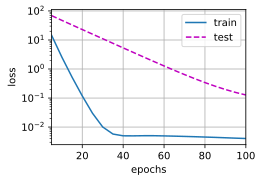

In [8]:
train(lambd=3)

##框架实现版本

In [9]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 12.599514961242676


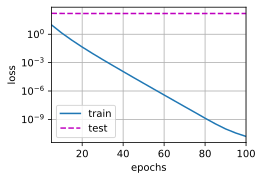

In [10]:
train_concise(0)

w的L2范数： 0.3552964925765991


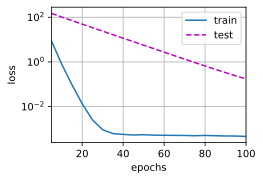

In [11]:
train_concise(3)